# Image Denoising With Variational Inference

In this exercise you will implement image denoising with variational inference using the Mean-Field approximation on an Ising model.

For reading image files, this code requires the Python Pillow package.

The following cell provides some useful functionality.

In [88]:
from PIL import Image           # pillow
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng
rng = default_rng()


def readImg(imgname):
    img = np.asarray(Image.open(imgname + '.png'), dtype=np.float64)[:,:,0]
    off = (np.max(img) - np.min(img)) / 2
    img -= off
    img /= off
    return img  # matrix containing values -1 and 1


def perturbNormal(img, sigma):
    return img + rng.normal(size=img.shape, scale=sigma)

def perturbFlip(img, frac):
    imgNoisy = np.copy(img)
    imgNoisy[rng.uniform(0, 1, size=img.shape) < frac] *= -1
    return imgNoisy


def showImg(img):
    plt.imshow(img, cmap='gray')

def show2Imgs(clean, noisy):
    fig, (axClean, axNoisy) = plt.subplots(1,2)
    axClean.imshow(clean, cmap='gray')
    axClean.set_title=('Clean Image')
    axNoisy.imshow(noisy, cmap='gray')
    axNoisy.set_title=('Noisy Image')

def show3Imgs(img01, img02, img03):
    fig, (axImg01, axImg02, axImg03) = plt.subplots(1,3)
    axImg01.imshow(img01, cmap='gray')
    axImg02.imshow(img02, cmap='gray')
    axImg03.imshow(img03, cmap='gray')

Create and display your noisy image here:

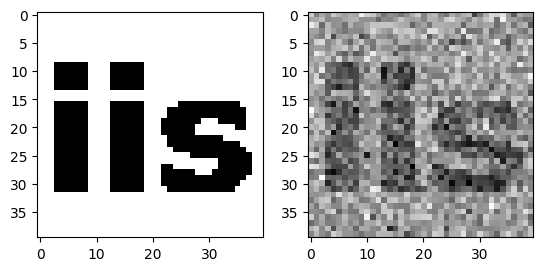

In [89]:
img = readImg('iis')                          # also try other images
if True:                                      # set to True or False to choose your noise
    imgNoisy = perturbNormal(img, 1)          # 2nd arg is standard deviation of noise
else:
    imgNoisy = perturbFlip(img, 0.2)          # 2nd arg is proportion of flipped pixels
    
show2Imgs(img, imgNoisy)

Implement your solution in the following code block.

In our specific Ising model,
$$p(\mathbf{z}) = \frac{1}{Z_0} \exp\left(\sum_i \sum_{j\in\textrm{nbr}(i)} z_i z_j\right)$$
The linking matrix $W_{i j}$ is all ones and can thus be omitted.

In the Gaussian likelihood function
$$
\begin{array}{rcl}
p(\mathbf{x}|\mathbf{z}) &=& \displaystyle \prod_i \exp(\ell_i(z_i)) \\
\ell_i(z_i) &=& \displaystyle -\frac{1}{2\sigma^2} (x_i - z_i)^2 \;=\; \log p(x_i|z_i) + Z_1
\end{array}
$$
the normalization factor $Z_1$ can be disregarded because it will cancel in the update rule. The value of $\sigma$ is a model parameter that is to be passed to the function `denoise()`.

In [90]:
# Returns a denoised version of the nparray img using the Mean-Field approximation.
# img is a noisy version of a binary image; true pixel states are -1 or 1.
# sigma is the standard deviation of the normal distribution governing the likelihood function p(x|z).
# dampfac is the lambda parameter from the update rule (lambda is a keyword in Python...)
# niters gives the number of iterations, that is, the number of times the update rule is applied.
def denoise(img, sigma, dampfac, niters):
    ### BEGIN YOUR CODE HERE
    l_plus_arr = -(1 / (2 * sigma ** 2)) * (img - 1) ** 2
    l_minus_arr = -(1 / (2 * sigma ** 2)) * (img + 1) ** 2
    l_diff_arr = (l_plus_arr - l_minus_arr) / 2

    imgDenoised = np.copy(img)
    height, width = img.shape
    for iter in range(niters):
        mean_new = np.copy(imgDenoised)
        for i in range(height):
            for j in range(width):
                # mean-field influence on z_ij: m_ij
                m_ij = 0
                neighbors = [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                for n_i, n_j in neighbors:
                    if 0 <= n_i < height and 0 <= n_j < width:
                        m_ij += imgDenoised[n_i, n_j]

                # update mean using damped mean-field update
                a_ij = m_ij + l_diff_arr[i, j]
                mean_old = imgDenoised[i, j]
                mean_new[i, j] = (1 - dampfac) * mean_old + dampfac * np.tanh(a_ij)
        imgDenoised = mean_new
    return imgDenoised
    ### END YOUR CODE HERE

Now test your code:

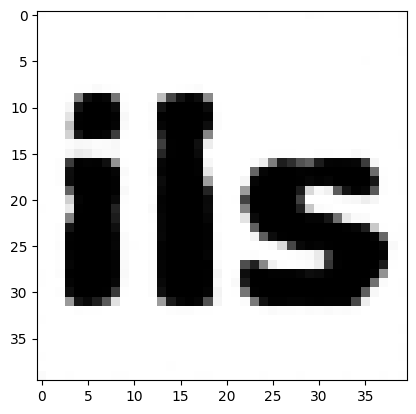

In [91]:
imgDenoised = denoise(imgNoisy, 2, 0.5, 10)
showImg(imgDenoised)

Play with different versions of `sigma`, `dampfac`, and `niters`. Explain your observations below, including illustrations generated with `showImg(imgDenoised)`.

## My Observations

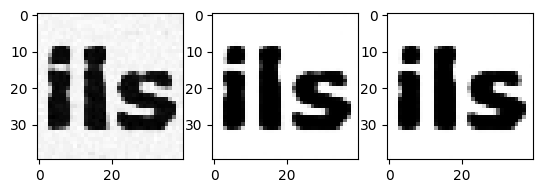

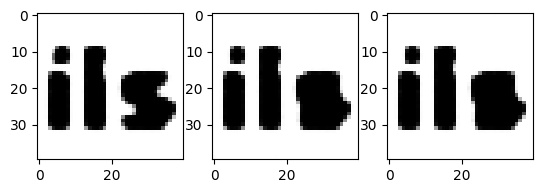

In [92]:
# Different versions of niters:
# niters = (5, 10, 15)
imgDenoised01 = denoise(imgNoisy, 2, 0.5, 5)
imgDenoised02 = denoise(imgNoisy, 2, 0.5, 10)
imgDenoised03 = denoise(imgNoisy, 2, 0.5, 15)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)

# niters = (50, 250, 1000)
imgDenoised01 = denoise(imgNoisy, 2, 0.5, 50)
imgDenoised02 = denoise(imgNoisy, 2, 0.5, 250)
imgDenoised03 = denoise(imgNoisy, 2, 0.5, 1000)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)

### Different versions of `niters`

I experimented with different numbers of iterations: 5, 10, 15, 50, 250 and 1000. The corresponding denoised images are shown above.

We can observe that the algorithm already denoises the image very effectively after only 5 to 15 iterations. The characters "iis" become clearly recognizable and most of the noise is removed.

However, when running the algorithm for a larger number of iterations, such as 50, 250 or even 1000, the quality of the denoised image seems to become worse. The characters start to deform into large black shapes. One possible reason for this behavior could be the nature of the Mean-Field approximation. Since the method works with mean values, information from neighboring pixels is aggregated over the iterations. As a result, small local differences may get smoothed out, and fine structures are lost. Over many iterations, this aggregation effect could lead to overly confident regions and cause the characters to blur into large black shapes.

---

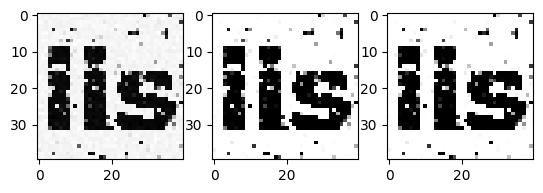

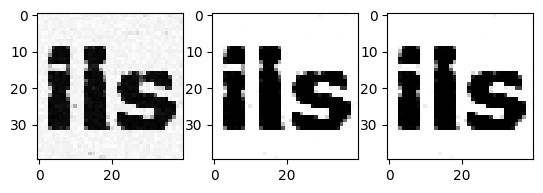

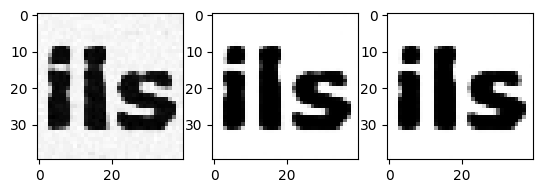

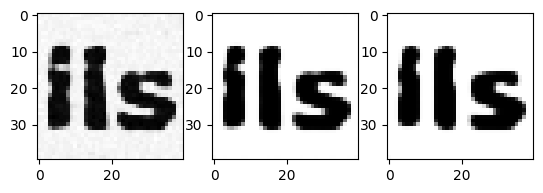

In [93]:
# Different versions of sigma:
# sigma = 0.5
imgDenoised02 = denoise(imgNoisy, 0.5, 0.5, 10)
imgDenoised01 = denoise(imgNoisy, 0.5, 0.5, 5)
imgDenoised03 = denoise(imgNoisy, 0.5, 0.5, 15)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)
# sigma = 1
imgDenoised01 = denoise(imgNoisy, 1, 0.5, 5)
imgDenoised02 = denoise(imgNoisy, 1, 0.5, 10)
imgDenoised03 = denoise(imgNoisy, 1, 0.5, 15)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)
# sigma = 2
imgDenoised01 = denoise(imgNoisy, 2, 0.5, 5)
imgDenoised02 = denoise(imgNoisy, 2, 0.5, 10)
imgDenoised03 = denoise(imgNoisy, 2, 0.5, 15)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)
# sigma = 5
imgDenoised01 = denoise(imgNoisy, 5, 0.5, 5)
imgDenoised02 = denoise(imgNoisy, 5, 0.5, 10)
imgDenoised03 = denoise(imgNoisy, 5, 0.5, 15)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)

### Different versions of `sigma`

I experimented with different values of the standard deviation `sigma`: 0.5, 1, 2 and 5. The corresponding denoised images are shown above.

We can observe that for very small values of `sigma`, such as 0.5, the denoised images still show a noticeable amount of noise. This behavior can be explained by looking at the form of the likelihood function:

$$
\ell_i(z_i) = -\frac{1}{2\sigma^2}(x_i - z_i)^2
$$

When `sigma` is small, the factor $\frac{1}{2\sigma^2}$ becomes large. Thus, even small deviations between the observed noisy pixel $x_i$ and the latent variable $z_i$ cause a large penalty in the likelihood. As a result, the algorithm is strongly encouraged to set $z_i$ close to $x_i$, even if $x_i$ is noisy. In other words, the model "trusts" the observations too much.

As `sigma` increases, the penalty for deviations between $x_i$ and $z_i$ becomes smaller. This means the algorithm relies less on the noisy observations and more on the prior information, which encourages neighboring pixels to take similar values. The denoised images become smoother, as the model gives more weight to spatial coherence instead of individual noisy measurements. However, this smoothing effect comes at the cost of losing fine details, especially around edges and corners. At very high `sigma` values, the characters appear overly rounded and blurry, and some structural sharpness is lost.

Thus, `sigma` controls the trade-off between trusting the noisy observations versus enforcing smoothness based on the prior.

---

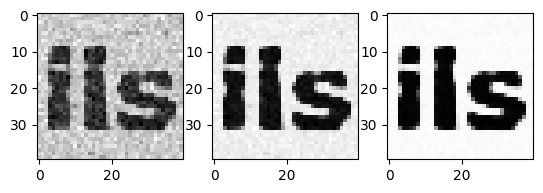

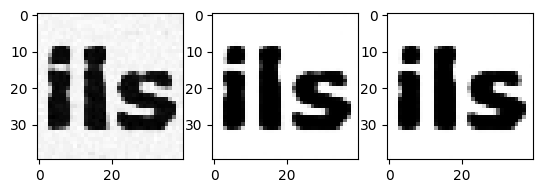

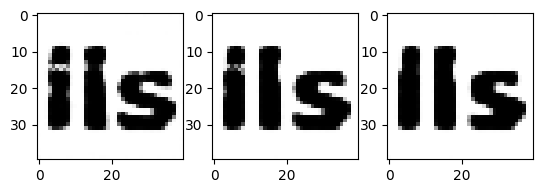

In [94]:
# Different versions of dampfac:
# dampfac = 0.25
imgDenoised01 = denoise(imgNoisy, 2, 0.25, 5)
imgDenoised02 = denoise(imgNoisy, 2, 0.25, 10)
imgDenoised03 = denoise(imgNoisy, 2, 0.25, 15)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)
# dampfac = 0.5
imgDenoised01 = denoise(imgNoisy, 2, 0.5, 5)
imgDenoised02 = denoise(imgNoisy, 2, 0.5, 10)
imgDenoised03 = denoise(imgNoisy, 2, 0.5, 15)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)
# dampfac = 0.75
imgDenoised01 = denoise(imgNoisy, 2, 0.75, 5)
imgDenoised02 = denoise(imgNoisy, 2, 0.75, 10)
imgDenoised03 = denoise(imgNoisy, 2, 0.75, 15)
show3Imgs(imgDenoised01, imgDenoised02, imgDenoised03)

### Different versions of `dampfac`

I experimented with different values of the damping factor: 0.25, 0.5 and 0.75. The corresponding denoised images after 5, 10 and 15 iterations are shown above.

As we can see especially for the version with only 5 iterations, higher values of `dampfac` lead to faster convergence of the algorithm. This behavior is consistent with the damped mean-field update formula:

$$
\mu_{i,j}^{\text{new}} = (1-\lambda) \mu_{i,j}^{\text{old}} + \lambda \tanh(a_{i,j})
$$

The larger the damping factor $\lambda$, the less influence the old mean value has and the faster the mean adapts to the newly computed value.
